In [100]:
import random
import numpy as np
import matplotlib
import numba
import time
import multiprocessing as mp
from numba import jit, prange
from numba import config, njit, threading_layer
from matplotlib import pyplot as plt

In [101]:
#random.seed(1235)
#Demand function from Klein (2020)
@njit
def PD_rewards(p1,p2):
    x = np.array(
            [[(3,3), (0,5)],
            [(5,0), (1,1)]]
             )
    val_p1, val_p2 = x[p1,p2]
    
    return val_p1, val_p2
        

In [102]:

@njit
def master_q_player(prices, Q, epsilon, p2,t):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[t,:,p2]))
    return p3

In [103]:
@njit
def npc_player(options, q_table, epsilon, prev, time):
    if prev[time-1]==0 and prev[time]==0:
        npc_choice = 0
    else:
        npc_choice = 1
    return npc_choice

In [104]:
@njit
def regular_update(Q, prev, alpha, delta, prices, indic):
    # if indic == 1: 
    #     p1 = prices[prev[0,0]]
    #     p2 = prices[prev[1,0]]
    #     p22 = prices[prev[1,1]]
    #     pe1 = Q[prev[0,0],prev[1,0]]
    #     ne1 = p1*PD_rewards(p1,p2) + delta* p1*PD_rewards(p1,p22) + delta**2 * Q[np.argmax(Q[:,prev[1,1]]),prev[1,1]]
    #     Q[prev[0,0], prev[1,0]] = (1-alpha) * pe1 + alpha * ne1
    #     #print('GAME player 1 ne and pe', ne1, pe1)
    # else: 
        p1 = prev[1,0]
        p2 = prev[0,0]
        p22 = prev[0,1]
        pe2 = Q[prev[1,0],prev[0,0]]
        ne2 = p1*PD_rewards(p1,p2)[1] + delta* p1*PD_rewards(p1,p22)[1] + delta**2 * Q[np.argmax(Q[:,prev[0,1]]),prev[0,1]]
        Q[prev[1,0], prev[0,0]] = (1-alpha) * pe2 + alpha * ne2

@njit
def simple_Q_learner(prices, Q, epsilon, p2):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[:,p2]))
    return p3

In [105]:

@njit
def update(Q, prev, alpha, delta, prices, Current_t, previous_t, time, interval):
        my_old_price = prev[0,0]
        their_old_price = prev[1,0]
        their_new_choice = prev[1,1]
        intervals = np.shape(Q)[0]
        
        # Current_t = numba.int64(np.floor(time/interval_size))
        # previous_t = numba.int64(np.floor((time-1)/interval_size))
                
        #print('indices',prev[0,0],prev[1,0],prev_time)
        #print('prices', my_old_price, their_new_choice, their_old_price)
        prev_q_est = Q[previous_t, prev[0,0],prev[1,0]]
        #print('PD_reward', PD_rewards(my_old_price,their_old_price))
        #print('argmax i Q', Q[Current_t, np.argmax(Q[Current_t,:,prev[1,1]]),prev[1,1]])
        #print("PREV", prev[0,1])
        
        
        
        new_q_est = PD_rewards(my_old_price,their_old_price)[0] + delta* PD_rewards(my_old_price,their_new_choice)[0] + delta ** 2 * Q[Current_t, np.argmax(Q[Current_t,:,prev[1,1]]),prev[1,1]]
        #print("New Q est", new_q_est)
        prev_interval = max(0,Current_t-1)
        next_interval = min(intervals-1, Current_t+1)
        
        #print("operation",(time/interval) - Current_t)
        #if (time/interval) - Current_t < 0.5:
        #        prev_w = 0.5 - abs((time/interval) - prev_interval )
        #        curr_w = 1-prev_w
        #        Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + prev_w * Q[prev_interval, prev[0,0], prev[1,0]])
        #else:
        #        next_w = 0.5 - abs((time/interval) - next_interval) 
        #        curr_w = 1-next_w
        #        Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + next_w * Q[next_interval, prev[0,0], prev[1,0]])


        w_1 =  ( next_interval - time/interval) / (next_interval - prev_interval)
        w_2 =  (time/interval - prev_interval) / (next_interval-prev_interval) 
        #print('VÆGTE!!!:', w_1, w_2) 
        Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (w_2 * new_q_est + w_1 * Q[next_interval, prev[0,0], prev[1,0]])
        #curr_w = 1-prev_w
        #Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + next_w * Q[next_interval, prev[0,0], prev[1,0]] + prev_w * Q[prev_interval, prev[0,0], prev[1,0]])

In [137]:
@njit
def PD_game(q_table, options, periods, alpha, theta, delta):
    a = len(options)
    Simple_Q_Table = np.zeros((a, a))
    interval_size = periods/15
    print("interval",interval_size)
    prev_choices = np.zeros((2,2), dtype=numba.int64)
    reward_arr = np.zeros(int(periods-2))
    reward_arr_p2 = np.zeros(int(periods-2))
    all_choices1 =np.zeros(int(periods/2)-1)
    all_choices2 =np.zeros(int(periods/2)-1)
    i_counter = 0
    j_counter = 0
    t=3
    if np.shape(q_table) != (15,a,a):
        print("Wrong dimensions")
    else:
        for t in range(t, periods+1):
        
            epsilon = (1-theta)**t
            if t % 2 != 0: 
                time_for_q = int(np.floor(t/interval_size))
                prev_time_for_q = int(np.floor((t-1)/interval_size))
                #print("TimeCHeck",time_for_q,time_for_q)
                #print('time for q', time_for_q, 'prev time for q', prev_time_for_q, "prev", prev_choices)
                update(q_table, prev_choices, alpha, delta, options, time_for_q, prev_time_for_q, t, interval_size)
                
                
                p_i = master_q_player(options, q_table, epsilon, prev_choices[1,1], time_for_q)
                
                prev_choices[0,0] = prev_choices[0,1]
                prev_choices[0,1] = p_i
                prev_choices[1,0] = prev_choices[1,1]
                all_choices1[i_counter] = (options[p_i])
                i_counter += 1
                #print('Spiller 1 tur: p:', prices[p_i],' p_j: ', prices[prev_p[1,1]],'iteration:', t,'Q_table: \n', Q_table)
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
            else: 
                #In Case of Q opponent:
                regular_update(Simple_Q_Table, prev_choices, alpha, delta, options, 2)
                p_j = simple_Q_learner(options, Simple_Q_Table, epsilon, prev_choices[0,1])
                #a hard coded opponent: 
                #p_j= npc_player(options, q_table, 0, all_choices1,j_counter)
                
                
                prev_choices[1,0] = prev_choices[1,1]
                prev_choices[1,1] = p_j
                prev_choices[0,0] = prev_choices[0,1]
                all_choices2[j_counter] = (options[p_j])
                j_counter += 1
                #print('Spiller 2 tur: p:', prices[p_j], 'p_i', prices[prev_p[0,1]],' iteration: ', t,'Q_table2: \n', Q_table2)
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
                #step_counter +=1
    return all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table





    
    

In [132]:
def many_games(prices, periods, alpha, theta, learners, delta, init_q):
    total_pro_arr = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_pro_arr2 = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_opt_arr = np.zeros((learners, 49), dtype = np.ndarray)
    avg_profit = np.zeros(learners)
    avg_profit2 = np.zeros(learners)
    change_arr = np.zeros((1,25))
    change_arr2 = np.zeros((1,25))
    init_Q = init_q #np.zeros((10,2,2))
    for i in range(learners):
        print('run #',i+1 ,'of ', learners , 'runs')
        all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table = PD_game(init_Q, prices, periods, alpha, theta, delta)
        total_pro_arr[i] = reward_arr
        total_pro_arr2[i] = reward_arr_p2
        #total_opt_arr[i] = arr_opt_i
        avg_profit[i] = np.mean(reward_arr[-10000:])
        avg_profit2[i] = np.mean(reward_arr_p2[-10000:])
        init_Q = q_table
        
    return total_pro_arr, total_pro_arr2, avg_profit, avg_profit2, init_Q

In [133]:
options = np.array([0,1])
init_Q = np.zeros((15,2,2))
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q = many_games(options, 100000, 0.3, 0.0000922, 50 ,0.95, init_Q)
final_Q

run # 1 of  50 runs
interval 6666.666666666667
run # 2 of  50 runs
interval 6666.666666666667
run # 3 of  50 runs
interval 6666.666666666667
run # 4 of  50 runs
interval 6666.666666666667
run # 5 of  50 runs
interval 6666.666666666667
run # 6 of  50 runs
interval 6666.666666666667
run # 7 of  50 runs
interval 6666.666666666667
run # 8 of  50 runs
interval 6666.666666666667
run # 9 of  50 runs
interval 6666.666666666667
run # 10 of  50 runs
interval 6666.666666666667
run # 11 of  50 runs
interval 6666.666666666667
run # 12 of  50 runs
interval 6666.666666666667
run # 13 of  50 runs
interval 6666.666666666667
run # 14 of  50 runs
interval 6666.666666666667
run # 15 of  50 runs
interval 6666.666666666667
run # 16 of  50 runs
interval 6666.666666666667
run # 17 of  50 runs
interval 6666.666666666667
run # 18 of  50 runs
interval 6666.666666666667
run # 19 of  50 runs
interval 6666.666666666667
run # 20 of  50 runs
interval 6666.666666666667
run # 21 of  50 runs
interval 6666.666666666667
r

array([[[60.        , 51.38992012],
        [52.67129116, 47.01908845]],

       [[60.        , 52.23152861],
        [53.79094612, 49.03059535]],

       [[60.        , 53.25197098],
        [53.82649254, 49.12595446]],

       [[60.        , 53.3408731 ],
        [54.02582343, 49.46889957]],

       [[60.        , 53.3588168 ],
        [54.10634207, 48.86902102]],

       [[60.        , 53.35878319],
        [54.10616798, 47.94866939]],

       [[60.        , 53.35881001],
        [54.10581171, 44.46561627]],

       [[60.        , 53.35890119],
        [54.10634382, 31.9486799 ]],

       [[60.        , 53.35895511],
        [54.10581823,  0.51873969]],

       [[60.        , 53.3595772 ],
        [54.09823263,  0.        ]],

       [[60.        , 53.36060941],
        [54.07343241,  6.3561077 ]],

       [[60.        , 53.36547328],
        [53.98137408,  0.        ]],

       [[60.        , 53.40659406],
        [53.86293858, 12.44388561]],

       [[60.        , 53.58326087],
  

In [134]:
def moving_avg(fst_arr, snd_arr, window_size):

    moving_averages = []
    moving_averages2 = []
    i = 0
    while i < len(fst_arr) - window_size + 1:
    
        # Calculate the average of current window
        window_average = np.sum(fst_arr[
        i:i+window_size]) / window_size
        window_average2 = np.sum(snd_arr[
        i:i+window_size]) / window_size
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        moving_averages2.append(window_average2)

        
        # Shift window to right by one position
        i += 1
    return moving_averages, moving_averages2

def prof_means(prof_arr1, prof_arr2):
    return np.mean(prof_arr1, axis=0), np.mean(prof_arr2, axis=0)

In [135]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

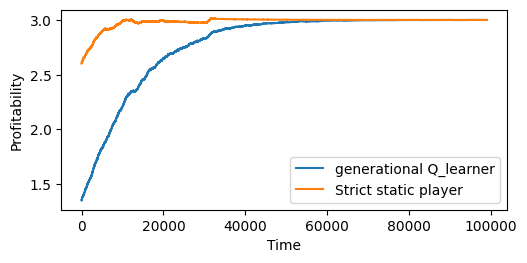

In [136]:

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='generational Q_learner')
plt.plot(t_arr2,profitability_arr2,'-', label='Strict static player')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

In [112]:
np.shape(rewards_p1)

(50, 99998)

In [140]:
first_fivep1 = rewards_p1[0:5,:]
first_fivep2 = rewards_p2[0:5,:]

last_fivep1 = rewards_p1[-5:,:]
last_fivep2 = rewards_p2[-5:,:]

In [141]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

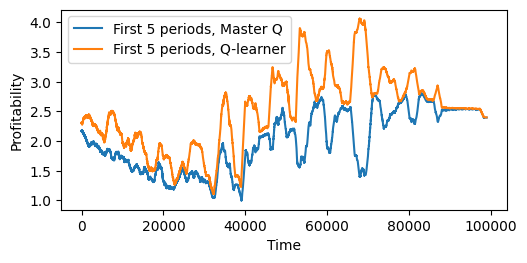

In [144]:
profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, 1000)
t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1_5,'-',label='First 5 periods, Master Q')
plt.plot(t_arr2,profitability_first2_5,'-', label='First 5 periods, Q-learner')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

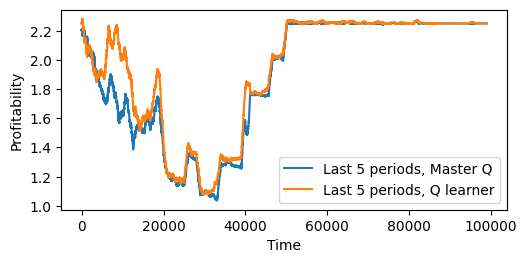

In [146]:
profitability_last1_5, profitability_last2_5 = moving_avg(last_prof1_5, last_prof2_5, 1000)
t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_last1_5,'-',label='Last 5 periods, Master Q')
plt.plot(t_arr2,profitability_last2_5,'-', label='Last 5 periods, Q learner')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

In [121]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

In [138]:
options = np.array([0,1])
init_Q = np.zeros((15,2,2))
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q2 = many_games(options, 100000, 0.3, 0.0000922, 50 ,0.95, final_Q)
final_Q

run # 1 of  50 runs
interval 6666.666666666667
run # 2 of  50 runs
interval 6666.666666666667
run # 3 of  50 runs
interval 6666.666666666667
run # 4 of  50 runs
interval 6666.666666666667
run # 5 of  50 runs
interval 6666.666666666667
run # 6 of  50 runs
interval 6666.666666666667
run # 7 of  50 runs
interval 6666.666666666667
run # 8 of  50 runs
interval 6666.666666666667
run # 9 of  50 runs
interval 6666.666666666667
run # 10 of  50 runs
interval 6666.666666666667
run # 11 of  50 runs
interval 6666.666666666667
run # 12 of  50 runs
interval 6666.666666666667
run # 13 of  50 runs
interval 6666.666666666667
run # 14 of  50 runs
interval 6666.666666666667
run # 15 of  50 runs
interval 6666.666666666667
run # 16 of  50 runs
interval 6666.666666666667
run # 17 of  50 runs
interval 6666.666666666667
run # 18 of  50 runs
interval 6666.666666666667
run # 19 of  50 runs
interval 6666.666666666667
run # 20 of  50 runs
interval 6666.666666666667
run # 21 of  50 runs
interval 6666.666666666667
r

array([[[41.56096781, 42.23757407],
        [48.32474772, 44.55953524]],

       [[31.55810266, 27.14870459],
        [36.69809684, 31.31216197]],

       [[32.05630779, 23.87319715],
        [33.32744565, 24.47495297]],

       [[44.65747585, 43.51539879],
        [45.13490824, 29.58858888]],

       [[28.10632042, 20.3254275 ],
        [28.42465781, 23.94341901]],

       [[35.74224508, 22.06066263],
        [34.56748263, 22.12795356]],

       [[36.65404417, 20.97981874],
        [36.23264488, 21.08277065]],

       [[45.77118566, 44.3137107 ],
        [45.94314181, 41.7232669 ]],

       [[45.50566337, 44.31348781],
        [45.94292276, 41.9581035 ]],

       [[45.44705397, 44.31462668],
        [45.94408144, 41.9136286 ]],

       [[45.21543036, 44.39194639],
        [46.02271791, 41.84002859]],

       [[45.75921282, 44.31348765],
        [45.94292261, 41.33716664]],

       [[45.40654893, 44.31348765],
        [45.94292261, 39.9181505 ]],

       [[45.73937219, 44.31348765],
  

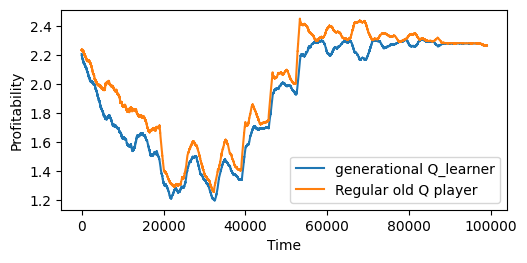

In [139]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='generational Q_learner')
plt.plot(t_arr2,profitability_arr2,'-', label='Regular old Q player')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

In [124]:

Q = np.zeros((10,2,2))

all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table = PD_game(Q, options, 10000, 0.3, 0.000322, 0.95)



interval 666.6666666666666
Wrong dimensions
